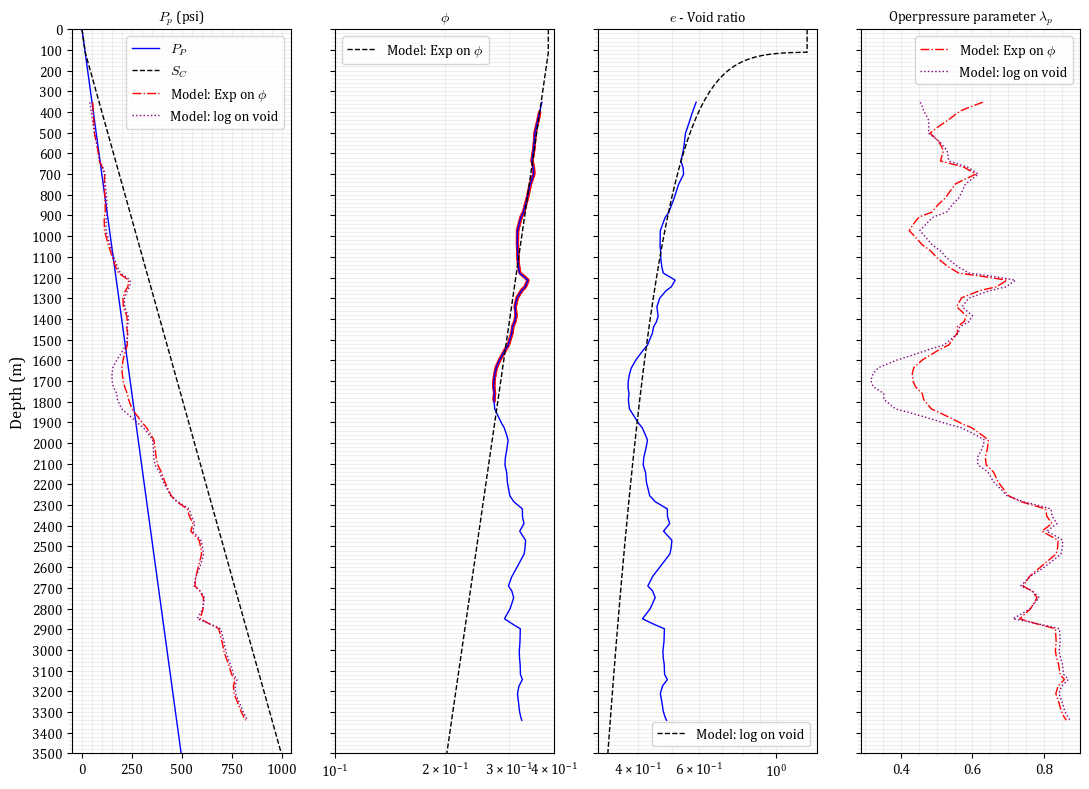

In [147]:
import numpy as np
from numpy import min, max
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

plt.style.use('default')   ## reset!
plt.style.use('paper.mplstyle')

DEPTH = np.arange(0, 3500, 1)
PP = 0.465 * 0.3048 * DEPTH

# Seaflor: 111.5m
GRAD = 0.950 * np.ones_like(DEPTH) #  > 111.5 m
GRAD[DEPTH<111.4] = 0.465 # See water gradient psi/ft
GRAD = GRAD * 0.3048  # to psi/m
SV = np.cumsum(GRAD)


df = pd.read_csv( 'hw8-por.csv' )
lin = interp1d( df.depth, df.por )
pormap = (DEPTH > df.depth.min()) & (DEPTH < df.depth.max())
DEPTH_POR = DEPTH[ pormap ]
POR = lin( DEPTH_POR )
VOID = POR / ( 1 - POR )
SV_POR = SV[pormap]

SIGV = SV - PP

porfit_map = (DEPTH > 400) & (DEPTH<1800)
POR_PORFIT = lin( DEPTH[porfit_map] )
VOID_PORFIT = POR_PORFIT / ( 1 - POR_PORFIT )

SIGV_PORFIT = SIGV[porfit_map]
DEPTH_PORFIT = DEPTH[porfit_map]

#  Fit porosity
from scipy.optimize import curve_fit
def expPhi(sigv, phi0, beta):
    return phi0 * np.exp( -beta * sigv )
popt, pcov = curve_fit(expPhi, SIGV_PORFIT, POR_PORFIT, [0.2,0.0001] )
mphi_phi0 = popt[0]
mphi_beta = popt[1]
POR_FIT = expPhi(SIGV, *popt)
# Extrapolate Pp
mphi_PP_POR = SV_POR + 1/mphi_beta * np.log( POR / mphi_phi0 )
mphi_lambdap = mphi_PP_POR / SV_POR # Overpressure parameter - lambda_p = pp/sv

# Fit void ratio
def logVoid(sigv, e0, cc):
    return e0 - cc * np.log( sigv ) # sigv is given in psi. The log argument is "times psi"
popt, pcov = curve_fit(logVoid, SIGV_PORFIT, VOID_PORFIT )
mvoid_e0 = popt[0]
mvoid_cc = popt[1]
VOID_FIT = logVoid(SIGV, *popt)
# Extrapolate Pp
mvoid_PP_POR = SV_POR - np.exp(( mvoid_e0 - VOID) / mvoid_cc )
mvoid_lambdap = mvoid_PP_POR / SV_POR # Overpressure parameter - lambda_p = pp/sv


# fig, axs = plt.subplots(1, n_crv , sharey=True)
fig, axs = plt.subplots( 1, 4, sharey=True)
fig.set_size_inches(11,8)

ax = axs[0]
ax.set_ylim( min(DEPTH), max(DEPTH) )
ax.invert_yaxis()
ax.set_ylabel(f"Depth (m)")
ax.plot( PP, DEPTH, color='b', label='$P_P$' )
ax.plot( SV, DEPTH, color='k', ls='--', label='$S_C$' )
ax.plot( mphi_PP_POR, DEPTH_POR, c='r', ls='-.', label='Model: Exp on $\phi$' )
ax.plot( mvoid_PP_POR, DEPTH_POR, c='purple', ls='dotted', label='Model: log on void' )
ax.set_title( "$P_p$ (psi)" )
ax.set_yticks( np.linspace(0,3500,36) )
ax.legend()

ax = axs[1]
ax.plot( POR, DEPTH_POR, color='b' )
ax.plot( POR_FIT, DEPTH, color='k', ls='--', label='Model: Exp on $\phi$'  )
ax.scatter( POR_PORFIT, DEPTH_PORFIT, color='r', ls='--', marker='o', s=3, alpha=0.3 )
ax.set_xscale('log')
ax.set_xlim( 0.1, 0.4 )
ax.set_title("$\phi$")
ax.legend()

ax = axs[2]
ax.plot( VOID, DEPTH_POR, color='b' )
ax.plot( VOID_FIT, DEPTH, color='k', ls='--', label='Model: log on void'  )
#ax.scatter( POR_PORFIT, DEPTH_PORFIT, color='r', ls='--', marker='o', s=3, alpha=0.3 )
ax.set_xscale('log')
#ax.set_xlim( 0.1, 0.4 )
ax.set_title("$e$ - Void ratio")
ax.legend()

ax = axs[3]
ax.plot( mphi_lambdap, DEPTH_POR, color='r', ls='-.', label='Model: Exp on $\phi$' )
ax.plot( mvoid_lambdap, DEPTH_POR, color='purple', ls='dotted', label='Model: log on void'  )
#ax.scatter( POR_PORFIT, DEPTH_PORFIT, color='r', ls='--', marker='o', s=3, alpha=0.3 )
#ax.set_xlim( 0.1, 0.4 )
ax.set_title("Operpressure parameter $\lambda_p$")
ax.legend()


fig.tight_layout()

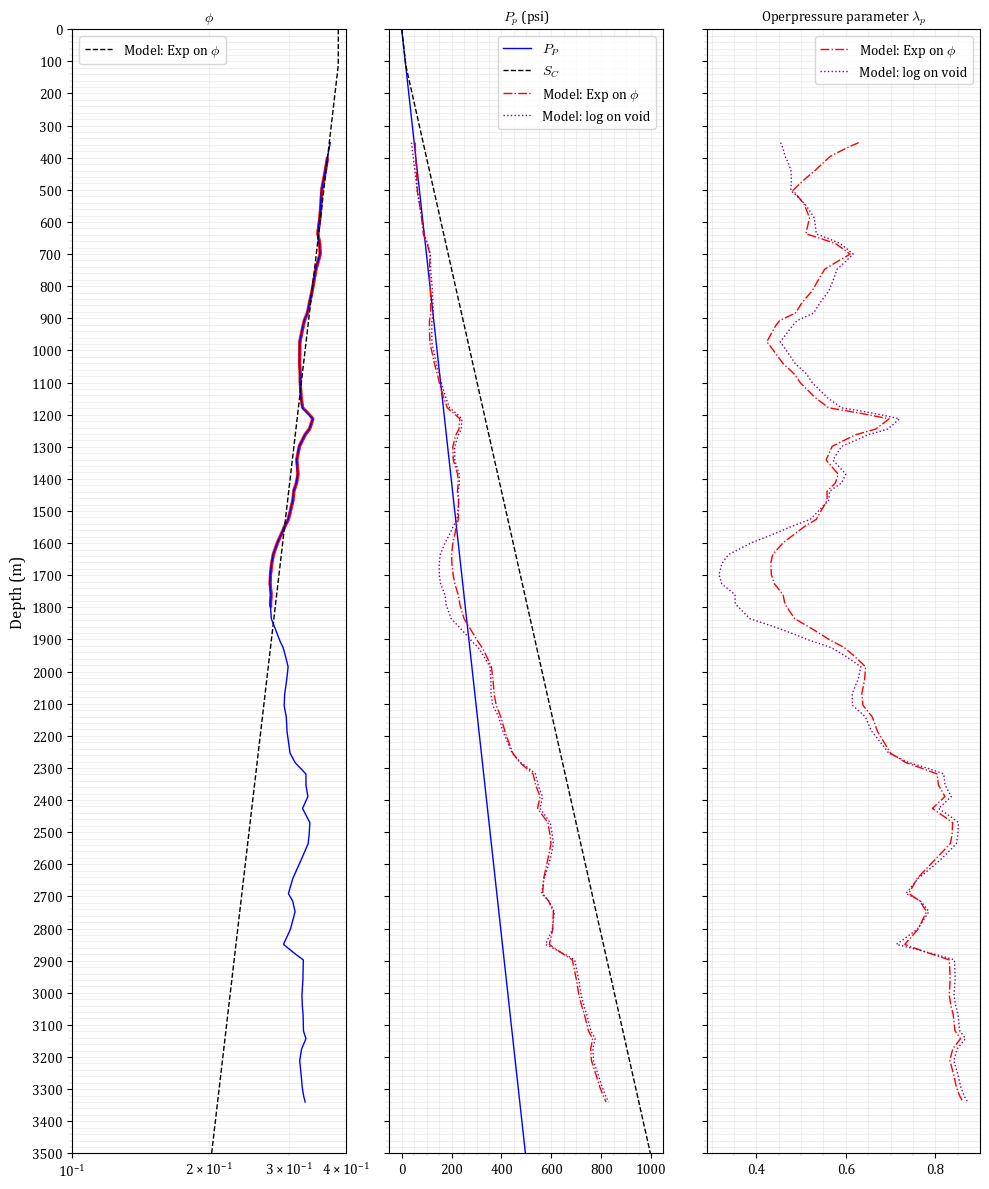

In [151]:
# fig, axs = plt.subplots(1, n_crv , sharey=True)
fig, axs = plt.subplots( 1, 3, sharey=True)
fig.set_size_inches(10,12)

ax = axs[0]
ax.plot( POR, DEPTH_POR, color='b' )
ax.plot( POR_FIT, DEPTH, color='k', ls='--', label='Model: Exp on $\phi$'  )
ax.scatter( POR_PORFIT, DEPTH_PORFIT, color='r', ls='--', marker='o', s=3, alpha=0.3 )
ax.set_xscale('log')
ax.set_xlim( 0.1, 0.4 )
ax.set_title("$\phi$")
ax.legend()
ax.set_ylabel(f"Depth (m)")

ax = axs[1]
ax.set_ylim( min(DEPTH), max(DEPTH) )
ax.invert_yaxis()
ax.plot( PP, DEPTH, color='b', label='$P_P$' )
ax.plot( SV, DEPTH, color='k', ls='--', label='$S_C$' )
ax.plot( mphi_PP_POR, DEPTH_POR, c='r', ls='-.', label='Model: Exp on $\phi$' )
ax.plot( mvoid_PP_POR, DEPTH_POR, c='purple', ls='dotted', label='Model: log on void' )
ax.set_title( "$P_p$ (psi)" )
ax.set_yticks( np.linspace(0,3500,36) )
ax.legend()

ax = axs[2]
ax.plot( mphi_lambdap, DEPTH_POR, color='r', ls='-.', label='Model: Exp on $\phi$' )
ax.plot( mvoid_lambdap, DEPTH_POR, color='purple', ls='dotted', label='Model: log on void'  )
#ax.scatter( POR_PORFIT, DEPTH_PORFIT, color='r', ls='--', marker='o', s=3, alpha=0.3 )
#ax.set_xlim( 0.1, 0.4 )
ax.set_title("Operpressure parameter $\lambda_p$")
ax.legend()

fig.tight_layout()